In [397]:
# first import data 
#sshfs ascott47@jhu.edu@gateway2.marcc.jhu.edu:/scratch/groups/bzaitch1/badr/ mountpoint/
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import matplotlib.cm as cm
import scipy.spatial
import os 
import string
import scipy.stats
## plotting details
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams['axes.color_cycle'] =['#d7191c','#fc8d59','#999999','#a6d96a','#1a9641','#3288bd']
matplotlib.rcParams['lines.linewidth'] = 3.0

home_dir = os.getenv("HOME")
#source activate python2
from netCDF4 import Dataset
from wrf import getvar
import wrf
from wrf import ALL_TIMES

# import ibutton data cleaned and bias corrected, calculated with CharacteristicsBaltimoreUHI
tempDF=pd.read_csv('data/correctedibuttontemp2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')['2016-07-01':'2016-08-30']#.first()
tempDF.columns = tempDF.columns.astype(int)
filepath = '../cityheat/Bmore/2016/'
meta = pd.DataFrame(pd.read_csv(filepath + 'data/CleanedMeta2016.csv', sep = ','))
meta = meta.set_index('sensornumber', drop = False)
meta = meta.set_index(meta.index.astype('float64'), drop = False)

# import model data generatured by ModelledCharacteristicsBaltimoreUHI.ipynb 
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d_%H:%M:%S') -pd.Timedelta('4h')
model = pd.read_csv('data/UCM+SST_d03_allpoints.csv',parse_dates=['Unnamed: 0'],date_parser=date_parser).set_index('Unnamed: 0')[tempDF.index[0]:tempDF.index[-1]]
model.columns = model.columns.astype(int)
# other variables
model_allvars = pd.read_csv('UCM+SST_d03_allpoints_allvars.csv',header = [0,1], index_col=0,
                        parse_dates = [0], 
                   date_parser = date_parser,
                       skipinitialspace=True)#[tempDF.index[0]:tempDF.index[-1]]
model_allvars.columns.set_levels(model_allvars.columns.levels[1].astype(int), level = 1, inplace = True)
net_lw = model_allvars['LWDNB'].subtract(model_allvars['LWUPB'])
net_sw = (model_allvars['SWDNB'].subtract(model_allvars['SWUPB']))#.add(model_allvars['net_lw'],axis=0)
rnet = net_lw+net_sw

# landcover 
lcc_english = {
    #! 40 CLASS MODIS (Outside US, cats 1-20)/NLCD (US only, cats 21-40) LU characterization
    # downloaded from https://github.com/yyr/wrf/blob/master/phys/module_sf_pxlsm_data.F March 8 2018
    1: 'Evergreen Needleleaf Forest',
    2:  'Evergreen Broadleaf Forest',
    3:  'Deciduous Needleleaf Forest',
    4:   'Deciduous Broadleaf Forest',
    5: 'Mixed Forest',
    6:  'Closed Shrublands', 
    7:'Open Shrublands', 
    8: 'Woody Savanna', 
    9:'Savanna', 
    10: 'Grasslands', 
    11: 'Perminent Wetlands', 
    12: 'Croplands',
    13: 'Urban andBuilt-up', 
    14: 'Cropland/Natural Vegetation Mosaic', 
    15: 'Snow and Ice', 
    16: 'Barren or Sparsely Vegetated', 
    17:  'IGBP water', 
    18: 'unclassified', 
    19: 'fill value (normally ocean water)', 
    20: 'unclassified', 
    21: 'Open water', 
    22: 'Perennial Ice/snow', 
    23: 'Developed, Open space', 
    24:'Developed, Low Intensity', 
    25: 'Developed, Medium Intensity', 
    26: 'Developed, High Intensity', 
    27: 'Barren land', 
    28: 'Deciduous Forest', 
    29: 'Evergreen Forest', 
    30: 'Mixed Forest',
    31: 'Dwarf Scrub', 
    32:  'Shrub/Scrub', 
    33: 'Grassland/Herbaceous', 
    34: 'Sedge/Herbaceous',
    35: 'Lichens', 
    36: 'Moss', 
    37: 'Pasture/Hay',
    38: 'Cultivated Crops',
    39: 'Woody Wetland',
    40: 'Emergent Herbaceous Wetland',
}

lcc = pd.read_csv('data/UCM+SST_d03_landcover.csv').set_index('Unnamed: 0')# index = meta.index, columns=['LCC'])
lcc['LCC English'] =  [lcc_english[int(x)]for x in lcc.LCC]
lcc.head()

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()


,LCC,LCC English
Unnamed: 0,,
82,23.0,"Developed, Open space"
139,25.0,"Developed, Medium Intensity"
130,28.0,Deciduous Forest
32,23.0,"Developed, Open space"
10,26.0,"Developed, High Intensity"


In [604]:
f = '/Users/ascott47/mountpoint/wrf/out/UCM+SST/d01/wrfout_d01_2016-06-25_00:00:00'
dataset = Dataset(f)
low_res = getvar(dataset, "LU_INDEX")

f = '/Users/ascott47/mountpoint/wrf/out/UCM+SST/d02/wrfout_d01_2016-06-25_00:00:00'
dataset = Dataset(f)
med_res = getvar(dataset, "LU_INDEX")

In [608]:
low_res.XLONG.min(), low_res.XLONG.max()

(<xarray.DataArray 'XLONG' ()>
 array(-85.5911865234375)
 Coordinates:
     XTIME    float32 44640.0
     Time     datetime64[ns] 2016-06-25, <xarray.DataArray 'XLONG' ()>
 array(-68.0057373046875)
 Coordinates:
     XTIME    float32 44640.0
     Time     datetime64[ns] 2016-06-25)

In [609]:
low_res.XLAT.min(), low_res.XLAT.max()

(<xarray.DataArray 'XLAT' ()>
 array(32.28853225708008)
 Coordinates:
     XTIME    float32 44640.0
     Time     datetime64[ns] 2016-06-25, <xarray.DataArray 'XLAT' ()>
 array(44.98015594482422)
 Coordinates:
     XTIME    float32 44640.0
     Time     datetime64[ns] 2016-06-25)

In [610]:
med_res.XLONG.min(), med_res.XLONG.max()

(<xarray.DataArray 'XLONG' ()>
 array(-78.8524169921875)
 Coordinates:
     XTIME    float32 44640.0
     Time     datetime64[ns] 2016-06-25, <xarray.DataArray 'XLONG' ()>
 array(-73.356689453125)
 Coordinates:
     XTIME    float32 44640.0
     Time     datetime64[ns] 2016-06-25)

In [611]:
med_res.XLAT.min(), med_res.XLAT.max()

(<xarray.DataArray 'XLAT' ()>
 array(36.81785202026367)
 Coordinates:
     XTIME    float32 44640.0
     Time     datetime64[ns] 2016-06-25, <xarray.DataArray 'XLAT' ()>
 array(40.98936462402344)
 Coordinates:
     XTIME    float32 44640.0
     Time     datetime64[ns] 2016-06-25)

In [613]:
lu.XLONG.min(), lu.XLONG.max()

(<xarray.DataArray 'XLONG' ()>
 array(-77.65386962890625)
 Coordinates:
     XTIME    float32 5400.0
     Time     datetime64[ns] 2016-05-28T18:00:00, <xarray.DataArray 'XLONG' ()>
 array(-75.86077880859375)
 Coordinates:
     XTIME    float32 5400.0
     Time     datetime64[ns] 2016-05-28T18:00:00)

In [614]:
lu.XLAT.min(), lu.XLAT.max()

(<xarray.DataArray 'XLAT' ()>
 array(38.275142669677734)
 Coordinates:
     XTIME    float32 5400.0
     Time     datetime64[ns] 2016-05-28T18:00:00, <xarray.DataArray 'XLAT' ()>
 array(39.663047790527344)
 Coordinates:
     XTIME    float32 5400.0
     Time     datetime64[ns] 2016-05-28T18:00:00)

(<xarray.DataArray u'xy' ()>
 array(100)
 Coordinates:
     latlon_coord  object CoordPair(lat=39.29813979, lon=-76.69014149)
     x_y           <U1 u'y', <xarray.DataArray u'xy' ()>
 array(128)
 Coordinates:
     latlon_coord  object CoordPair(lat=39.28520643, lon=-76.54833725)
     x_y           <U1 u'y')

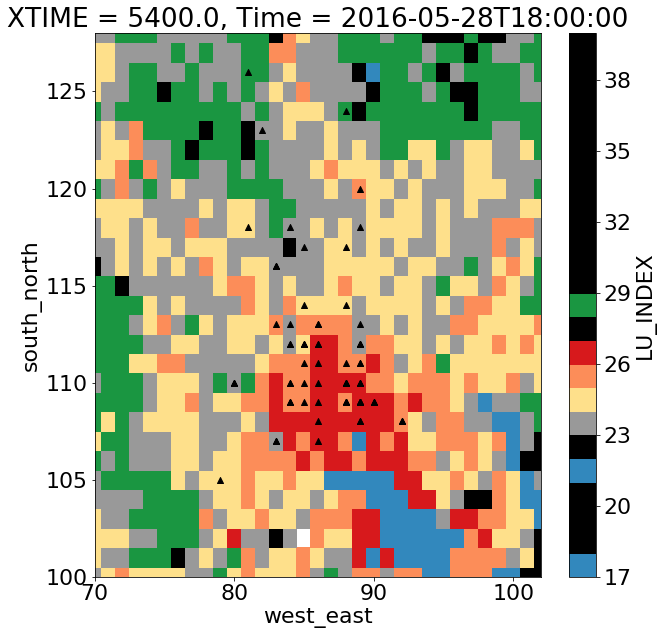

In [597]:
# Fig. 1: A map with insets, some points
# exp = 'UCM+SST'
# dom = 'd03'
# fpath = home_dir + '/mountpoint/wrf/out/'
# files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
# ds = Dataset(files[30*3])
# lu = getvar(ds, "LU_INDEX")
# all_pts = wrf.ll_to_xy(ds, meta['location:Latitude'].dropna().values,
#                        meta['location:Longitude'].dropna().values)
color_dict ={26.: '#d7191c',
             25 : '#fc8d59',
             24: '#fee08b', #'yellow',
             23: '#999999',
             28: '#1a9641', 
             21: '#3288bd',
             17: '#3288bd'
            }
cmap = ['k' for x in range(17,40)]
#cmap = ['#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3','#f5f5f5','#c7eae5','#80cdc1','#35978f','#01665e','#003c30', '#762a83','#af8dc3','#e7d4e8',]

for x in color_dict.keys(): 
    x = int(x)
    cmap[x-17] = color_dict[x]
#lu.plot(levels = 24, cmap  = cm.tab20, figsize = [10,10])
lu.plot(levels = 24,  
        cmap = cmap, 
        vmin = 17, vmax =40, figsize = [10,10])
plt.scatter(all_pts[0], all_pts[1], marker = '^', color = 'k')
# plt.xlim(pts[0].values)
# plt.ylim(pts[1].values)
plt.xlim(pts[0][0]-10, pts[0][1]+10)
plt.ylim(pts[1][0]-10, pts[1][1]+20)
#plt.savefig('figures/map.png')

In [617]:
meta.shape

(91, 17)

In [616]:
model.shape

(1461, 85)

In [618]:
meta.columns

Index([u'sensornumber', u'meta:instanceID', u'oldsensornumber',
       u'location:Latitude', u'location:Longitude', u'location:Altitude',
       u'location:Accuracy', u'direction', u'sunorshade', u'attachment',
       u'landcoverclass', u'vesasitenumber', u'vesacategory', u'picture',
       u'time', u'shield', u'notes'],
      dtype='object')

In [620]:
meta.shape

(91, 17)

In [631]:
(meta.loc[model.columns].landcoverclass=='impervious').sum()

24

In [632]:
(meta.loc[model.columns].landcoverclass=='grass').sum()

43

In [639]:
for l in meta.landcoverclass.unique(): 
    print(l,(meta.loc[model.columns].landcoverclass==l).sum() )

('impervious', 24)
('grass', 43)
('dirt', 13)
('grass impervious', 5)


In [638]:
for attach in meta.attachment.unique(): 
    print(attach, (meta.loc[model.columns].attachment==attach).sum())

('tree', 61)
('metal', 17)
('deadwood', 7)


In [641]:
for attach in meta.sunorshade.unique(): 
    print(attach, (meta.loc[model.columns].sunorshade==attach).sum())

('shade', 24)
('sun', 23)
('partial', 38)


In [647]:
# Station temperature/ibutton comparison 
# uncorrected data 
tempDF_uncorrected=pd.read_csv(filepath + 'data/CleanedTemp2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')['2016-07-01':'2016-08-31']#.first()
tempDF_uncorrected.columns = tempDF_uncorrected.columns.astype('int')
# asos data 
date_parser = pd.core.tools.datetimes.to_datetime # pd.datetools.to_datetime
asos = pd.read_csv('data/mdASOS_summer_2016.csv', parse_dates = ['valid'], date_parser = date_parser).set_index('valid')
asos.columns = ['station', 't_f', 't_c', 'dew_f', 'dew_c']
# correct for local time
asos.index = asos.index- pd.Timedelta('04:00:00')
### rearrange asos into obs dataframe
for column in ['t_f', 't_c', 'dew_f', 'dew_c']: 
    asos[column] = pd.to_numeric(asos[column],errors='coerce')
obs = pd.DataFrame(index = asos.resample('H').mean().index, columns = ['rural', 'urban'])
obs['urban'] =  asos[asos['station'] =='DMH']['t_c'].resample('H').mean()
obs['rural'] =  asos[asos['station'] =='BWI']['t_c'].resample('H').mean()

### set plotting details, like colors and linestyles
ibutton_linestyle = '-'
ibutton_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][-1]#'k'
asos_linestyle = '--'
asos_color = 'grey'#plt.rcParams['axes.prop_cycle'].by_key()['color'][1]#'blue'

# plt.figure(figsize = [15,5])
# #plot temp
# ax = plt.subplot(1,2,1)
# data = [tempDF_uncorrected['2016-07-01':'2016-08-31'][97], 
#         obs['2016-07-01':'2016-08-31']['urban'].dropna().values, 
#         tempDF_uncorrected[tempDF_uncorrected.index.hour ==6]['2016-07-01':'2016-08-31'][97],
#         obs[obs.index.hour==6]['2016-07-01':'2016-08-31']['urban'].dropna(), 
#         tempDF_uncorrected[tempDF_uncorrected.index.hour ==16]['2016-07-01':'2016-08-31'][97],
#         obs[obs.index.hour==16]['2016-07-01':'2016-08-31']['urban'].dropna(),         
#        ]
# #handles = plt.boxplot(data,positions=[0,1,2,3,4,5])
# handles = plt.boxplot(data[::2],positions=[0,1,2,3,4,5][::2], boxprops=(dict( linestyle=ibutton_linestyle,color='k')))
# handles2 = plt.boxplot(data[1::2],positions=[0,1,2,3,4,5][1::2], boxprops=(dict( linestyle=asos_linestyle,color='k')))
# labels = ['iButton, all hours', 'ASOS, all hours','iButton, 6am', 'ASOS,6am','iButton,4pm', 'ASOS, 4pm',]
# #x_handles = ax.set_xticklabels(labels,rotation='vertical')
# x_handles = plt.xticks([.5,2.5,4.5], ['All data', '6am data', '4pm data'])
# plt.xlim([-.5,5.5])

# handles = ax.boxplot(data[::2],positions=[0,1,2.5,3.5,5,6][::2],  
#                      boxprops=(dict( linestyle=ibutton_linestyle,linewidth=3, color=ibutton_color)), 
#                      whiskerprops=dict(color=ibutton_color,linewidth=3,),flierprops = dict(marker='x', color=ibutton_color),
#                     medianprops = dict(linestyle='-', color='k',linewidth=3,))
# handles2 = ax.boxplot(data[1::2],positions=[0,1,2.5,3.5,5,6][1::2], 
#                       boxprops=(dict( linestyle=asos_linestyle,color=asos_color,linewidth=3,)),
#                       whiskerprops=dict(color=asos_color,linewidth=3,),flierprops = dict(marker='x', color =asos_color),
#                       medianprops = dict(linestyle='-', color='k',linewidth=3,))
# x_handles = plt.xticks([.5,3,5.5], ['All hours', '6am', '4pm'])
# plt.xlim([-1,7])

# ax.set_title('a)') 
# ax.set_ylabel('Temperature ($^\circ C$)')

# ax = plt.subplot(1,2,2)
# tempDF_uncorrected['2016-07-01':'2016-08-31'][97].groupby(tempDF_uncorrected['2016-07-01':'2016-08-31'].index.hour).mean().plot(label = 'iButton', linestyle=ibutton_linestyle, color = ibutton_color)
# obs['2016-07-01':'2016-08-31']['urban'].groupby(obs['2016-07-01':'2016-08-31'].index.hour).mean().plot(label = 'ASOS', linestyle=asos_linestyle,color = asos_color)
# plt.legend(loc =2,frameon=False)
# ax.set_title('b)')
# ax.set_ylabel('Temperature ($^\circ C$)')
# ax.set_xlabel('Hour')
# #plt.savefig('figures/ibuttonbias.png')
# plt.savefig('figures/ibuttonbias.eps')

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
  app.launch_new_instance()


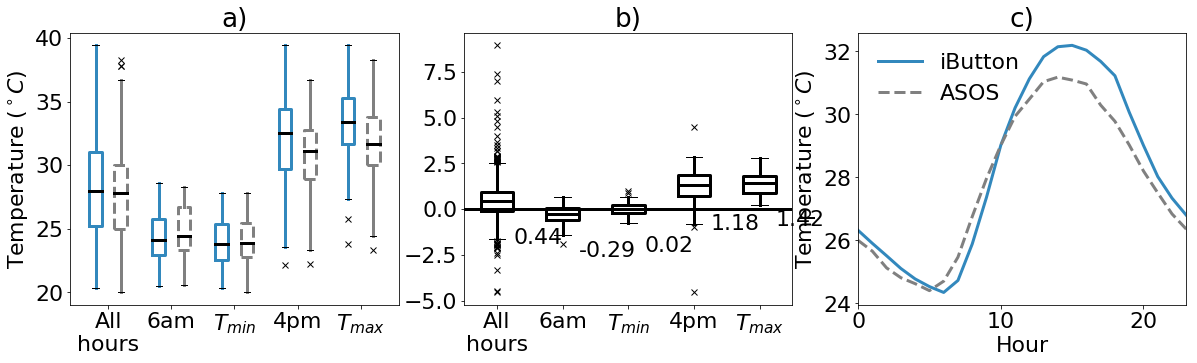

In [699]:
plt.figure(figsize = [20,5])
#plot temp
ax = plt.subplot(1,3,1)
data = [tempDF_uncorrected['2016-07-01':'2016-08-31'][97], 
        obs['2016-07-01':'2016-08-31']['urban'].dropna().values, 
        tempDF_uncorrected[tempDF_uncorrected.index.hour ==6]['2016-07-01':'2016-08-31'][97],
        obs[obs.index.hour==6]['2016-07-01':'2016-08-31']['urban'].dropna(), 
        tempDF_uncorrected['2016-07-01':'2016-08-31'][97].resample('D').min(),
        obs['2016-07-01':'2016-08-31']['urban'].resample('D').min().dropna(), 
        
        tempDF_uncorrected[tempDF_uncorrected.index.hour ==16]['2016-07-01':'2016-08-31'][97],
        obs[obs.index.hour==16]['2016-07-01':'2016-08-31']['urban'].dropna(),   
        tempDF_uncorrected['2016-07-01':'2016-08-31'][97].resample('D').max(),
        obs['2016-07-01':'2016-08-31']['urban'].resample('D').max().dropna(), 
       ]

handles = ax.boxplot(data[::2],positions=[0,1, 2.5,3.5, 5,6, 7.5, 8.5, 10, 11 ][::2],  
                     boxprops=(dict( linestyle=ibutton_linestyle,linewidth=3, color=ibutton_color)), 
                     whiskerprops=dict(color=ibutton_color,linewidth=3,),flierprops = dict(marker='x', color=ibutton_color),
                    medianprops = dict(linestyle='-', color='k',linewidth=3,))
handles2 = ax.boxplot(data[1::2],positions=[0,1, 2.5,3.5, 5,6, 7.5, 8.5, 10, 11 ][1::2], 
                      boxprops=(dict( linestyle=asos_linestyle,color=asos_color,linewidth=3,)),
                      whiskerprops=dict(color=asos_color,linewidth=3,),flierprops = dict(marker='x', color =asos_color),
                      medianprops = dict(linestyle='-', color='k',linewidth=3,))
x_handles = plt.xticks([.5,3,5.5, 8, 10.5], ['All\nhours', '6am', '$T_{min}$', '4pm', '$T_{max}$'])
plt.xlim([-1,12])

ax.set_title('a)') 
ax.set_ylabel('Temperature ($^\circ C$)')

ax = plt.subplot(1,3,2)
data = [(tempDF_uncorrected['2016-07-01':'2016-08-31'][97]-obs['2016-07-01':'2016-08-31']['urban']).dropna(), 
        (tempDF_uncorrected[tempDF_uncorrected.index.hour ==6]['2016-07-01':'2016-08-31'][97] - obs[obs.index.hour==6]['2016-07-01':'2016-08-31']['urban']).dropna(), 
        (tempDF_uncorrected['2016-07-01':'2016-08-31'][97].resample('D').min()- obs['2016-07-01':'2016-08-31']['urban'].resample('D').min()).dropna(), 
        (tempDF_uncorrected[tempDF_uncorrected.index.hour ==16]['2016-07-01':'2016-08-31'][97]- obs[obs.index.hour==16]['2016-07-01':'2016-08-31']['urban']).dropna(),   
        (tempDF_uncorrected['2016-07-01':'2016-08-31'][97].resample('D').max() - obs['2016-07-01':'2016-08-31']['urban'].resample('D').max()).dropna(), 
       ]
ax.axhline(0, color = 'k')
h = ax.boxplot(data, positions=[0,1,2,3,4],  
                     boxprops=(dict( linestyle='-',linewidth=3, color='k')), 
                     whiskerprops=dict(color='k',linewidth=3,),flierprops = dict(marker='x', color='k'),
                    medianprops = dict(linestyle='-', color='k',linewidth=3,))
for i in range(0,5): 
    mean = data[i].mean()
    ax.text(i+.25,mean-2,'%1.2f'%mean, verticalalignment='center')
x_handles = plt.xticks([0,1,2,3,4], ['All\nhours', '6am', '$T_{min}$', '4pm', '$T_{max}$'])
ax.set_title('b)')

ax = plt.subplot(1,3,3)
tempDF_uncorrected['2016-07-01':'2016-08-31'][97].groupby(tempDF_uncorrected['2016-07-01':'2016-08-31'].index.hour).mean().plot(label = 'iButton', linestyle=ibutton_linestyle, color = ibutton_color)
obs['2016-07-01':'2016-08-31']['urban'].groupby(obs['2016-07-01':'2016-08-31'].index.hour).mean().plot(label = 'ASOS', linestyle=asos_linestyle,color = asos_color)
plt.legend(loc =2,frameon=False)
ax.set_title('c)')
ax.set_ylabel('Temperature ($^\circ C$)')
ax.set_xlabel('Hour')
#plt.savefig('figures/ibuttonbias.png')
plt.savefig('figures/ibuttonbias.eps')

In [709]:
data = [(tempDF_uncorrected['2016-07-01':'2016-08-31'][97]-obs['2016-07-01':'2016-08-31']['urban']).dropna(), 
        (tempDF_uncorrected[tempDF_uncorrected.index.hour ==6]['2016-07-01':'2016-08-31'][97] - obs[obs.index.hour==6]['2016-07-01':'2016-08-31']['urban']).dropna(), 
        (tempDF_uncorrected['2016-07-01':'2016-08-31'][97].resample('D').min()- obs['2016-07-01':'2016-08-31']['urban'].resample('D').min()).dropna(), 
        (tempDF_uncorrected[tempDF_uncorrected.index.hour ==16]['2016-07-01':'2016-08-31'][97]- obs[obs.index.hour==16]['2016-07-01':'2016-08-31']['urban']).dropna(),   
        (tempDF_uncorrected['2016-07-01':'2016-08-31'][97].resample('D').max() - obs['2016-07-01':'2016-08-31']['urban'].resample('D').max()).dropna(), 
       ]
for i in range(0,5): 
    print(data[i].mean())

0.4446816609
-0.288533333333
0.019064516129
1.17725
1.41772580645


In [149]:
x = obs['2016-07-01':'2016-08-31']['urban'].dropna()
y = tempDF_uncorrected['2016-07-01':'2016-08-31'][97].dropna()
scipy.stats.pearsonr(x, y[x.index])

(0.96756173303551996, 0.0)

In [480]:
# rmse
from sklearn.metrics import mean_squared_error
# correlation 
# coefficient of determination: r**2
# hit rate 
def pbias(obs, sim): 
    return 100*(sim-obs).sum()/(obs).sum()
# index of agreement
def mioa(obs,sim,  j =2): 
    return 1 - (((obs-sim)**j).sum())/( (abs(sim-obs.mean())+abs(obs-obs.mean()))**j).sum() 
# # pretty print latex table : 
# vars = [rmse,correlation[0]]
# labels = ['RMSE', 'r']
# for var, label in zip(vars,labels): 
#     print('%s & %2.2f \\\\'%(label,var))

In [578]:
### compute error in space 
obs = tempDF_uncorrected.loc['2016-07-01':'2016-08-29', model.columns].mean(axis=0).values
sim = model['2016-07-01':'2016-08-29'].mean(axis=0).values

stats_df = pd.DataFrame(index = ['rmse', 'correlation', 'p-value', 'pbias' ,'mioa'])#, columns=['all data', 6, 16])
# all data 
stats_df.loc['rmse', 'all data'] = mean_squared_error(obs,sim)
stats_df.loc[['correlation', 'p-value'], 'all data'] = scipy.stats.pearsonr(obs,sim)
stats_df.loc['r_squared', 'all data'] = scipy.stats.pearsonr(obs,sim)[0]**2
stats_df.loc['pbias', 'all data'] = pbias(obs,sim)
stats_df.loc['mioa', 'all data'] = mioa(obs,sim)

# hourly data 
for hr in [6,16]: 
    obs = tempDF_uncorrected[tempDF_uncorrected.index.hour ==hr].loc[:'2016-08-29', model.columns].mean(axis=0).values
    sim = model[model.index.hour==hr][:'2016-08-29'].mean(axis=0).values
    stats_df.loc['rmse', hr] = mean_squared_error(obs,sim)
    stats_df.loc[['correlation', 'p-value'], hr] = scipy.stats.pearsonr(obs,sim)
    stats_df.loc['r_squared', hr] = scipy.stats.pearsonr(obs,sim)[0]**2
    stats_df.loc['pbias', hr] = pbias(obs,sim)
    stats_df.loc['mioa', hr] = mioa(obs,sim)
    
for hr in ['min', 'max']: 
    obs = tempDF_uncorrected.loc['2016-07-01':'2016-08-29', model.columns].resample('D', how = hr).mean(axis=0).values
    sim = model['2016-07-01':'2016-08-29'].resample('D', how = hr).mean(axis=0).values
    stats_df.loc['rmse', hr] = mean_squared_error(obs,sim)
    stats_df.loc[['correlation', 'p-value'], hr] = scipy.stats.pearsonr(obs,sim)
    stats_df.loc['r_squared', hr] = scipy.stats.pearsonr(obs,sim)[0]**2
    stats_df.loc['pbias', hr] = pbias(obs,sim)
    stats_df.loc['mioa', hr] = mioa(obs,sim)

print('Error in space', stats_df)

('Error in space',                  all data             6        16           min       max
rmse         9.332737e-01  3.315613e+00  3.698937  2.744835e+00  6.087859
correlation  6.435396e-01  5.239002e-01  0.461411  5.384820e-01  0.398209
p-value      3.082531e-11  2.669312e-07  0.000009  1.062557e-07  0.000160
pbias        7.787390e-01 -6.379852e+00  2.551613 -5.764737e+00  3.308640
mioa         6.860877e-01  5.541978e-01  0.451269  5.684483e-01  0.415107
r_squared    4.141432e-01  2.744714e-01  0.212901  2.899628e-01  0.158570)


/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:25: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:25: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()


In [579]:
print('Space error: '+  stats_df.to_latex(float_format=lambda x:'%2.2f'%x))#.replace('\n', ' '))

Space error: \begin{tabular}{lrrrrr}
\toprule
{} &  all data &     6 &   16 &   min &  max \\
\midrule
rmse        &      0.93 &  3.32 & 3.70 &  2.74 & 6.09 \\
correlation &      0.64 &  0.52 & 0.46 &  0.54 & 0.40 \\
p-value     &      0.00 &  0.00 & 0.00 &  0.00 & 0.00 \\
pbias       &      0.78 & -6.38 & 2.55 & -5.76 & 3.31 \\
mioa        &      0.69 &  0.55 & 0.45 &  0.57 & 0.42 \\
r\_squared   &      0.41 &  0.27 & 0.21 &  0.29 & 0.16 \\
\bottomrule
\end{tabular}



In [581]:
obs = tempDF_uncorrected.loc['2016-07-01':'2016-08-29', model.columns].mean(axis=1).values
sim = model['2016-07-01':'2016-08-29'].mean(axis=1).values

stats_df = pd.DataFrame(index = ['rmse', 'correlation', 'p-value', 'pbias' ,'mioa'])#, columns=['all data', 6, 16])
# all data 
stats_df.loc['rmse', 'all data'] = mean_squared_error(obs,sim)
stats_df.loc[['correlation', 'p-value'], 'all data'] = scipy.stats.pearsonr(obs,sim)
stats_df.loc['r_squared', 'all data'] = scipy.stats.pearsonr(obs,sim)[0]**2
stats_df.loc['pbias', 'all data'] = pbias(obs,sim)
stats_df.loc['mioa', 'all data'] = mioa(obs,sim)

# hourly data 
for hr in [6,16]: 
    obs = tempDF_uncorrected[tempDF_uncorrected.index.hour ==hr].loc['2016-07-01':'2016-08-29', model.columns].mean(axis=1).values
    sim = model[model.index.hour==hr]['2016-07-01':'2016-08-29'].mean(axis=1).values
    stats_df.loc['rmse', hr] = mean_squared_error(obs,sim)
    stats_df.loc[['correlation', 'p-value'], hr] = scipy.stats.pearsonr(obs,sim)
    stats_df.loc['r_squared', hr] = scipy.stats.pearsonr(obs,sim)[0]**2
    stats_df.loc['pbias', hr] = pbias(obs,sim)
    stats_df.loc['mioa', hr] = mioa(obs,sim)

for hr in ['min', 'max']: 
    obs = tempDF_uncorrected.loc['2016-07-01':'2016-08-29', model.columns].resample('D', how = hr).mean(axis=1).values
    sim = model['2016-07-01':'2016-08-29'].resample('D', how = hr).mean(axis=1).values
    stats_df.loc['rmse', hr] = mean_squared_error(obs,sim)
    stats_df.loc[['correlation', 'p-value'], hr] = scipy.stats.pearsonr(obs,sim)
    stats_df.loc['r_squared', hr] = scipy.stats.pearsonr(obs,sim)[0]**2
    stats_df.loc['pbias', hr] = pbias(obs,sim)
    stats_df.loc['mioa', hr] = mioa(obs,sim)
print('Time error: ', stats_df)

('Time error: ',              all data             6            16           min           max
rmse         4.601450  4.147685e+00  6.038084e+00  3.937321e+00  2.865623e+00
correlation  0.894613  8.399708e-01  7.629231e-01  8.201512e-01  9.011401e-01
p-value      0.000000  4.925047e-17  1.391145e-12  1.087524e-15  1.020706e-22
pbias        0.778739 -6.379852e+00  2.551613e+00 -5.764737e+00  3.308640e+00
mioa         0.933305  8.299194e-01  8.541625e-01  8.210240e-01  9.164267e-01
r_squared    0.800333  7.055510e-01  5.820517e-01  6.726480e-01  8.120534e-01)


/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()


In [582]:
print('%Time error: \n'+  stats_df.to_latex(float_format=lambda x:'%2.2f'%x))#.replace('\n', ' '))

Time error: \begin{tabular}{lrrrrr}
\toprule
{} &  all data &     6 &   16 &   min &  max \\
\midrule
rmse        &      4.60 &  4.15 & 6.04 &  3.94 & 2.87 \\
correlation &      0.89 &  0.84 & 0.76 &  0.82 & 0.90 \\
p-value     &      0.00 &  0.00 & 0.00 &  0.00 & 0.00 \\
pbias       &      0.78 & -6.38 & 2.55 & -5.76 & 3.31 \\
mioa        &      0.93 &  0.83 & 0.85 &  0.82 & 0.92 \\
r\_squared   &      0.80 &  0.71 & 0.58 &  0.67 & 0.81 \\
\bottomrule
\end{tabular}



In [ ]:
# lcz classification 
lcz_dict = {1: 'compact high-rise', #tens of stories, no trees, paved 
2: 'compact mid-rise', #3-9 stories, mostly paved
3: 'compact low-rise', #1-3 stories
6: 'Open low-rise', #abundance of pervious landcover, 1-3 stories
            8: 'sparesely built', 
'A': 'dense trees', # natural forest or urban park
'B': 'scattered trees', #natural forest or urban park
'D': 'low plants', #natural grassland, ag, or urban park
'G': 'water',
           }
# first, assume that everything is 3: compact low rise, impervious
lcz[[97, 77]] = 1
lcz[[]] = 2

# rural or urban forest- A
68, 75, 103, 63, 4,  33.0, 13.0, 28.0, 47.0, 16.0,  4.0, 43.0, 22.0,  29.0, 21.0, 44.0, 20
# suburban 9
130, 121 # Ben's house, 75, could also maybe be here? 
# open low-rise, 6, essentially Roland park type housing
73, 64, 94, 127,123, 128, 129, 85, 83 
# Vesa's open category, park, D 
144,4, 53, 20, meta[meta['vesacategory'] == 'o'].index
# compact mid-rise , 2
88
# scattered trees, B 
11.0,12,  54, 34.0,32.0, 

# dense housing, aka rowhomes, 3
74, 108, 79, 84, 72

In [154]:
lcz_dict = {1: 'compact high-rise', #tens of stories, no trees, paved 
2: 'compact mid-rise', #3-9 stories, mostly paved
3: 'compact low-rise', #1-3 stories
6: 'Open low-rise', #abundance of pervious landcover, 1-3 stories
            9: 'sparesely built', 
'A': 'dense trees', # natural forest or urban park
'B': 'scattered trees', #natural forest or urban park
'D': 'low plants', #natural grassland, ag, or urban park
'G': 'water',
           }

In [189]:
lcc['lcz'] = np.ones(lcc.shape[0])*3
sel = [97, 77]
lcc.loc[sel,'lcz'] = 1

sel = [68, 75, 103, 63, 4,  33.0, 13.0, 28.0, 47.0, 16.0,  4.0, 43.0, 22.0,  29.0, 21.0, 44.0, 20]
lcc.loc[sel,'lcz'] = 'A'
sel = [130]#, 121 ]
lcc.loc[sel,'lcz'] = 9
sel = [73, 64, 94, 127,123, 128, 129, 85, 83 ]
lcc.loc[sel,'lcz'] = 6
#sel = [144,4, 53, 20, meta[meta['vesacategory'] == 'o'].index]
sel = [x for x in meta[meta['vesacategory'] == 'o'].index.values] + [144,4, 53, 20,]
sel =np.setdiff1d(sel, 41)
lcc.loc[sel,'lcz'] = 'D'
lcc.loc[88, 'lcz'] = 2
sel = [11.0,12,  54, 34.0,32.0, ]
lcc.loc[sel, 'lcz'] = 'B'
sel = [74, 108, 79,  72] # 84,
lcc.loc[sel, 'lcz'] = 3
lcc['LCZ English'] =  [lcz_dict[x]for x in lcc.lcz]

In [ ]:
#### error tables 
# error in space 
# error in time 

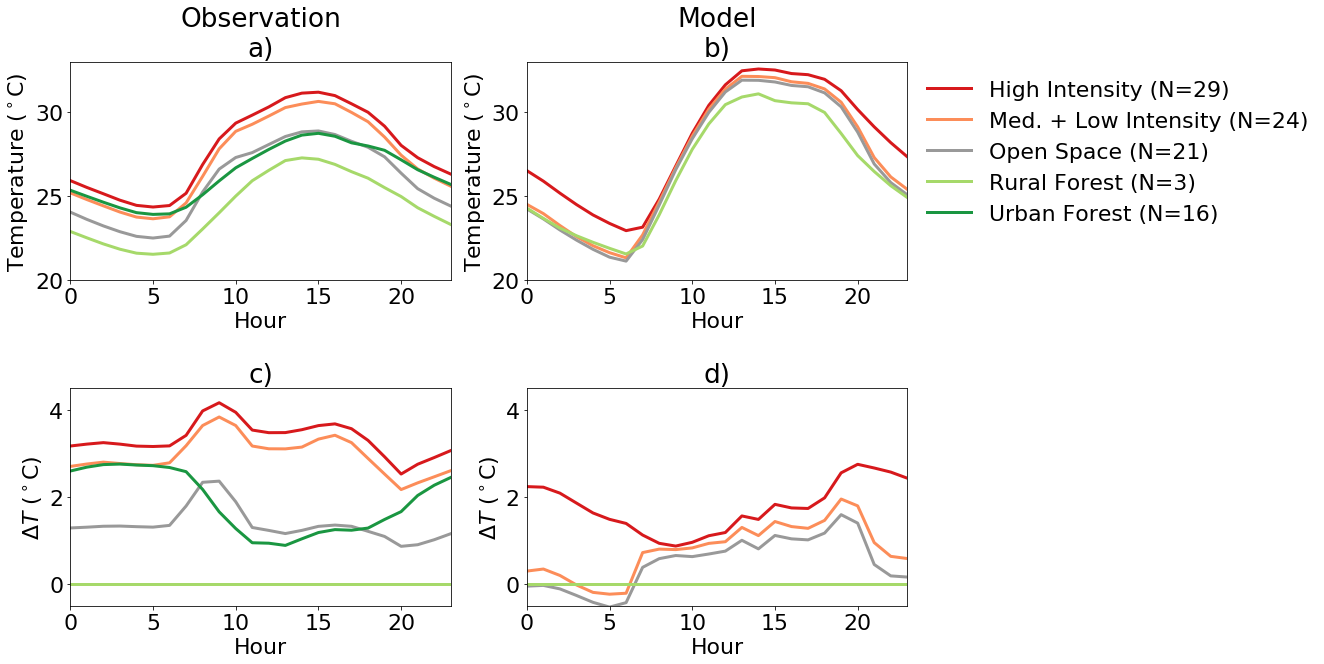

In [345]:
plt.figure(figsize= [15,10])
model_urban =  model[lcc[lcc.LCC ==26].index].groupby(model.index.hour).mean().mean(axis=1)
model_rural =  model[lcc[lcc.LCC ==28].index].groupby(model.index.hour).mean().mean(axis=1)
obs_rural = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().mean(axis=1)
#obs_rural = tempDF[[130]].groupby(tempDF.index.hour).mean().mean(axis=1)

ax = plt.subplot(2,2,1)
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25: 
        tempDF[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
tempDF[meta[meta.vesacategory =='f'].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = 'Urban forest (N = %i)'%meta[meta.vesacategory =='f'].index.shape[0] ,ax=ax)
#tempDF[meta[meta.vesacategory =='o'].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = 'Urban park (N = %i)'%meta[meta.vesacategory =='o'].index.shape[0] ,ax=ax)
ax.set_title('Observation\na)')
ax.set_ylabel('Temperature ($^\circ$C)')
#plt.legend(np.concatenate([selected_labels.label.values, ['ASOS']],axis=0))
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
#labels = ['High Intensity' ,'Med. + Low Intensity', 'Open Space', 'Rural Forest']
labels = ['High Intensity (N=29)' ,'Med. + Low Intensity (N=24)', 'Open Space (N=21)', 'Rural Forest (N=3)', 'Urban Forest (N=16)']
plt.legend(labels, bbox_to_anchor=(2.2, 1.01),loc=2,frameon=False)

ax = plt.subplot(2,2,2)
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25:
        model[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
#plt.legend()
ax.set_title('Model\nb)')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_ylim([20,33])
ax.set_xlabel('Hour')

# plot DT
ax = plt.subplot(2,2,3)
#tempDF.subtract(tempDF[103], axis=0).groupby(tempDF.index.hour).mean()[selected].plot(ax=ax, legend = False)
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc ==28: 
        tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(label = lcc_english[lc],ax=ax)
    else: 
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
        (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).plot(label = lcc_english[lc],ax=ax)
tempDF[meta[meta.vesacategory =='f'].index].groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(label = 'Urban forest (N = %i)'%meta[meta.vesacategory =='f'].index.shape[0] ,ax=ax)

    #plt.legend()
ax.set_title('c)')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')

#plt.legend(np.concatenate([selected_labels.label.values, ['SciCenter ASOS']],axis=0))
ax.set_ylim([-.5,4.5])
ax.set_xlabel('Hour')

# plot DT
ax = plt.subplot(2,2,4)
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
    (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural).plot(label = lcc_english[lc],ax=ax)

ax.set_title('d)')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_ylim([-.5,4.5])
#plt.legend(labels,loc=2,frameon=False)
plt.subplots_adjust(hspace=.5)
plt.savefig('figures/diurnal.eps',bbox_inches='tight')

In [7]:
# Map of mean temperature and mean model temp

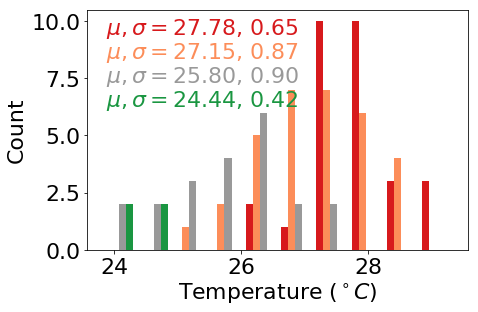

In [757]:
# Histogram of temperature by lancover type
fig = plt.figure(figsize=[15,15])
ax = plt.subplot(3,2,1)
data = [#tempDF.dropna().mean().values.flatten(), # all data
        tempDF[lcc[(lcc.LCC==26)].index].mean(),
        tempDF[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean(),#.dropna().values.flatten(),  #
        tempDF[lcc[(lcc.LCC==23)].index].mean(),#.dropna().values.flatten(), 
        tempDF[[68, 75, 130, 103]].mean(),#.dropna().values.flatten(),
       ]

ax.hist(data)
i = 0
for d in data: 
    ax.annotate('$\mu, \sigma =$%2.2f, %2.2f'%(np.nanmean(d),np.nanstd(d)), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    i = i+1
ax.set_xlabel('Temperature ($^\circ C$)')
ax.set_ylabel('Count')
#labels = ['Developed, High Intensity' ,'Developed, Med. + Low Intensity', 'Developed, Open Space', 'Deciduous Forest']
#plt.legend(['High Intensity' ,'Med. + Low Intensity', 'Open Space', 'Rural Forest', 'Urban Forest'])

In [730]:
data = [#tempDF.dropna().mean().values.flatten(), # all data
        tempDF[lcc[(lcc.LCC==26)].index].mean(),
        tempDF[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean(),#.dropna().values.flatten(),  #
        tempDF[lcc[(lcc.LCC==23)].index].mean(),#.dropna().values.flatten(), 
        tempDF[[68, 75, 130, 103]].mean(),#.dropna().values.flatten(),
       ]
for d in data: 
    print(np.std(d))

0.649206950896
0.865931231628
0.896248308451
0.418704380754


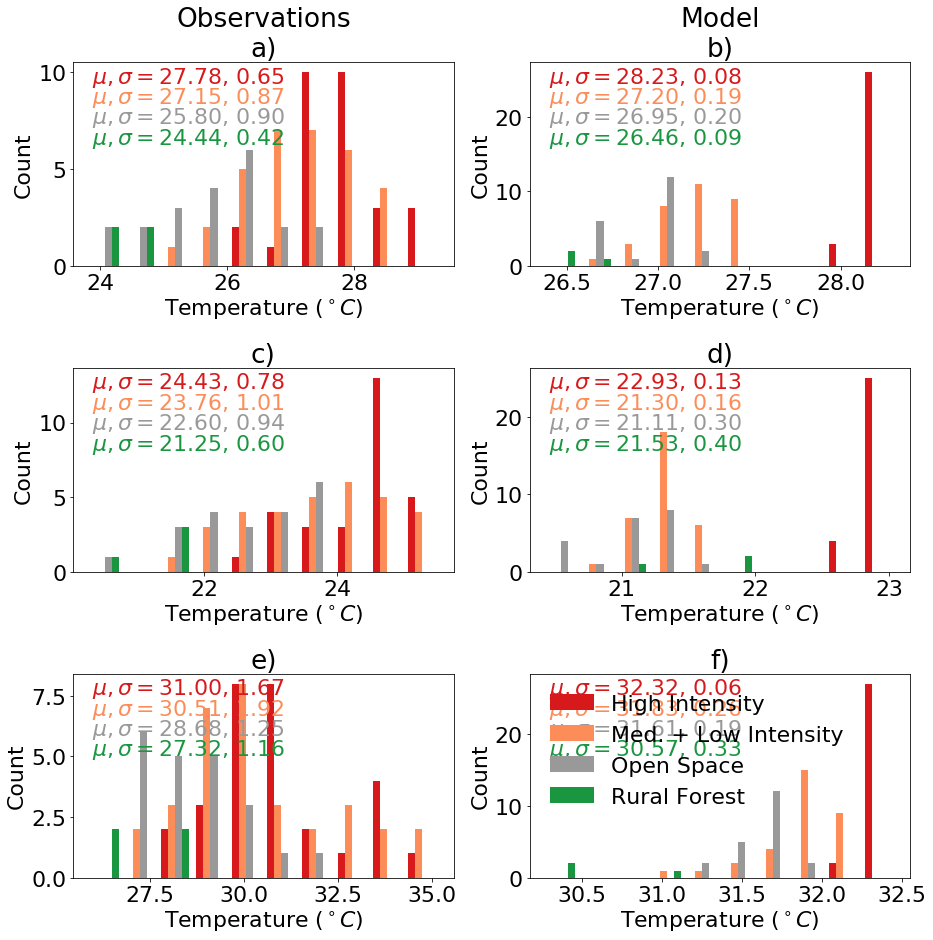

In [760]:
# Histogram of temperature by lancover type
fig = plt.figure(figsize=[15,15])
ax = plt.subplot(3,2,1)
data = [#tempDF.dropna().mean().values.flatten(), # all data
        tempDF[lcc[(lcc.LCC==26)].index].mean(),
        tempDF[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean(),#.dropna().values.flatten(),  #
        tempDF[lcc[(lcc.LCC==23)].index].mean(),#.dropna().values.flatten(), 
        tempDF[[68, 75, 130, 103]].mean(),#.dropna().values.flatten(),
       ]
i = 0
for d in data: 
    ax.annotate('$\mu, \sigma =$%2.2f, %2.2f'%(np.nanmean(d),np.nanstd(d)), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
#    ax.annotate('$\mu=$%2.2f'%np.nanmean(d), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    i = i+1

ax.hist(data)
ax.set_title('Observations\na)')
ax.set_xlabel('Temperature ($^\circ C$)')
ax.set_ylabel('Count')
#labels = ['Developed, High Intensity' ,'Developed, Med. + Low Intensity', 'Developed, Open Space', 'Deciduous Forest']
labels = ['High Intensity' ,'Med. + Low Intensity', 'Open Space', 'Rural Forest']
#plt.legend(labels,loc =2)

ax = plt.subplot(3,2,2)
data = [#tempDF.dropna().mean().values.flatten(), # all data
        model.dropna()[lcc[(lcc.LCC==26)].index].mean(),
        model.dropna()[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean(),#.dropna().values.flatten(),  #
        model.dropna()[lcc[(lcc.LCC==23)].index].mean(),#.dropna().values.flatten(), 
        model.dropna()[lcc[lcc.LCC ==28].index].mean(),#.dropna().values.flatten(),
       ]
ax.hist(data)
#plt.legend(labels,loc =2)#bbox_to_anchor=(1.1, 1.01))
i = 0
for d in data: 
    ax.annotate('$\mu, \sigma =$%2.2f, %2.2f'%(np.nanmean(d),np.nanstd(d)), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
#    ax.annotate('$\mu=$%2.2f'%np.nanmean(d), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    i = i+1

ax.set_xlabel('Temperature ($^\circ C$)')
ax.set_ylabel('Count')
ax.set_title('Model\nb)')

iii = 3
for hr in [6,16]: 
    ax = plt.subplot(3,2,iii)
    data = [#tempDF.dropna().mean().values.flatten(), # all data
        tempDF[tempDF.index.hour ==hr][lcc[(lcc.LCC==26)].index].mean(),
        tempDF[tempDF.index.hour ==hr][lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean(),#.dropna().values.flatten(),  #
        tempDF[tempDF.index.hour ==hr][lcc[(lcc.LCC==23)].index].mean(),#.dropna().values.flatten(), 
        tempDF[tempDF.index.hour ==hr][[68, 75, 130, 103]].mean(),#.dropna().values.flatten(),
       ]
    ax.hist(data)
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#    ax.set_title('%s) %s o\'clock data'%(string.ascii_lowercase[iii-1],hr))
    ax.set_xlabel('Temperature ($^\circ C$)')
    ax.set_ylabel('Count')
    i = 0
    for d in data: 
        ax.annotate('$\mu, \sigma =$%2.2f, %2.2f'%(np.nanmean(d),np.nanstd(d)), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
#        ax.annotate('$\mu=$%2.2f'%np.nanmean(d), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
        i = i+1

    iii =iii+1
    
    ax = plt.subplot(3,2,iii)

    data = [#tempDF.dropna().mean().values.flatten(), # all data
        model[model.index.hour ==hr][lcc[(lcc.LCC==26)].index].mean(),
        model[model.index.hour ==hr][lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean(),#.dropna().values.flatten(),  #
        model[model.index.hour ==hr][lcc[(lcc.LCC==23)].index].mean(),#.dropna().values.flatten(), 
        model[model.index.hour ==hr][lcc[lcc.LCC ==28].index].mean(),#.dropna().values.flatten(),
       ]
    ax.hist(data)
    i = 0
    for d in data: 
        ax.annotate('$\mu, \sigma =$%2.2f, %2.2f'%(np.nanmean(d),np.nanstd(d)), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
#        ax.annotate('$\mu=$%2.2f'%np.nanmean(d), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
        i = i+1

    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#    ax.set_title('%s) %s o\'clock data'%(string.ascii_lowercase[iii-1],hr))
    ax.set_xlabel('Temperature ($^\circ C$)')
    ax.set_ylabel('Count')
    iii =iii+1
plt.legend(labels,frameon=False)
plt.subplots_adjust(hspace=.5)
plt.savefig('figures/landcover_distribution.eps')

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in double_scalars


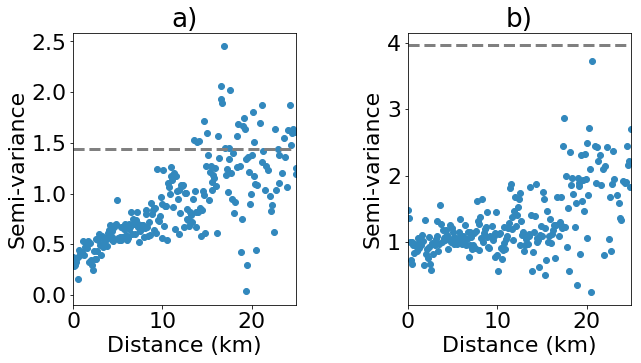

In [775]:
# Observations
r_earth = 6371
pts_df = pts.T.to_pandas()
pts_df.index = meta['location:Longitude'].dropna().index
labels = ['All Data', 'Developed, High Intensity' ,'Developed, Med. + Low Intensity', 'Developed, Open Space', 'Deciduous Forest']

# labels = ['All Data', 'Developed, Open space + Developed, Low Intensity',
#  'Developed, Medium + High Intensity',
# # 'Developed, High Intensity',
#  'Deciduous Forest']
#fig =plt.figure(figsize=[25,10])
fig =plt.figure(figsize=[10,5])

iii = 1
caption = []
#### clean this data!!!!    
locations0 = meta[['location:Longitude', 'location:Latitude']]
data0 = tempDF.mean()

locations1 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==26].index]# np.array([meta['location:Longitude'][lcc[lcc.LCC ==26].index].dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data1 = tempDF.mean()[lcc[lcc.LCC ==26].index]

locations2 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data2= tempDF.mean()[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]#.values

locations3 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==23].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data3= tempDF.mean()[lcc[lcc.LCC ==23].index]#.values

locations4 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==28].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data4= tempDF.mean()[lcc[lcc.LCC ==28].index]#.values


hs = np.linspace(0,25,251)
bandwidth =np.abs(hs[1]-hs[0])
#    for data,locations,label in zip([data0,data1,data2,data3,data4], [locations0,locations1,locations2, locations3,locations4], labels):
label = 'All data'
    # clean data 
for hr in [6,16]: 
    locations = locations0
    data = tempDF[tempDF.index.hour==hr].mean()
    ind = ~np.isnan(locations.iloc[:,0])& ~np.isnan(data)
    data = data[ind].values
    locations = locations[ind].values

    N = data.shape[0]
#    ax = plt.subplot(2,5,iii)
    ax = plt.subplot(1,2,iii)
    semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
    for h in hs:
        Z = []
        for i in range(N): 
            for j in range(i+1,N): 
                #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                if (distance >= h) and (distance< h+bandwidth):
                    Z.append(np.abs(data[i] - data[j])) 
        semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
    ax.scatter(semivariogram.index, semivariogram.semivariogram, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][-1])
    ax.axhline(data.var(), linestyle ='--', color = 'gray')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#        ax.set_title('%s , %i o\'clock '%(label,hr))
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Semi-variance')
    #ax.set_ylim([0,1.5])
    ax.set_xlim([0,25])
    caption.append('(%s) %s , %i o\'clock,'%(string.ascii_lowercase[iii-1],label,hr))
    iii = iii+1
plt.subplots_adjust(hspace=.5,wspace =0.5)
plt.savefig('figures/semivariogram_obs.eps')

In [776]:
hs[2]-hs[1]

0.10000000000000001

In [ ]:
tempDF

In [336]:
print(caption)

["(a) All Data , 6 o'clock,", "(b) Developed, High Intensity , 6 o'clock,", "(c) Developed, Med. + Low Intensity , 6 o'clock,", "(d) Developed, Open Space , 6 o'clock,", "(e) Deciduous Forest , 6 o'clock,", "(f) All Data , 16 o'clock,", "(g) Developed, High Intensity , 16 o'clock,", "(h) Developed, Med. + Low Intensity , 16 o'clock,", "(i) Developed, Open Space , 16 o'clock,", "(j) Deciduous Forest , 16 o'clock,"]


/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in double_scalars


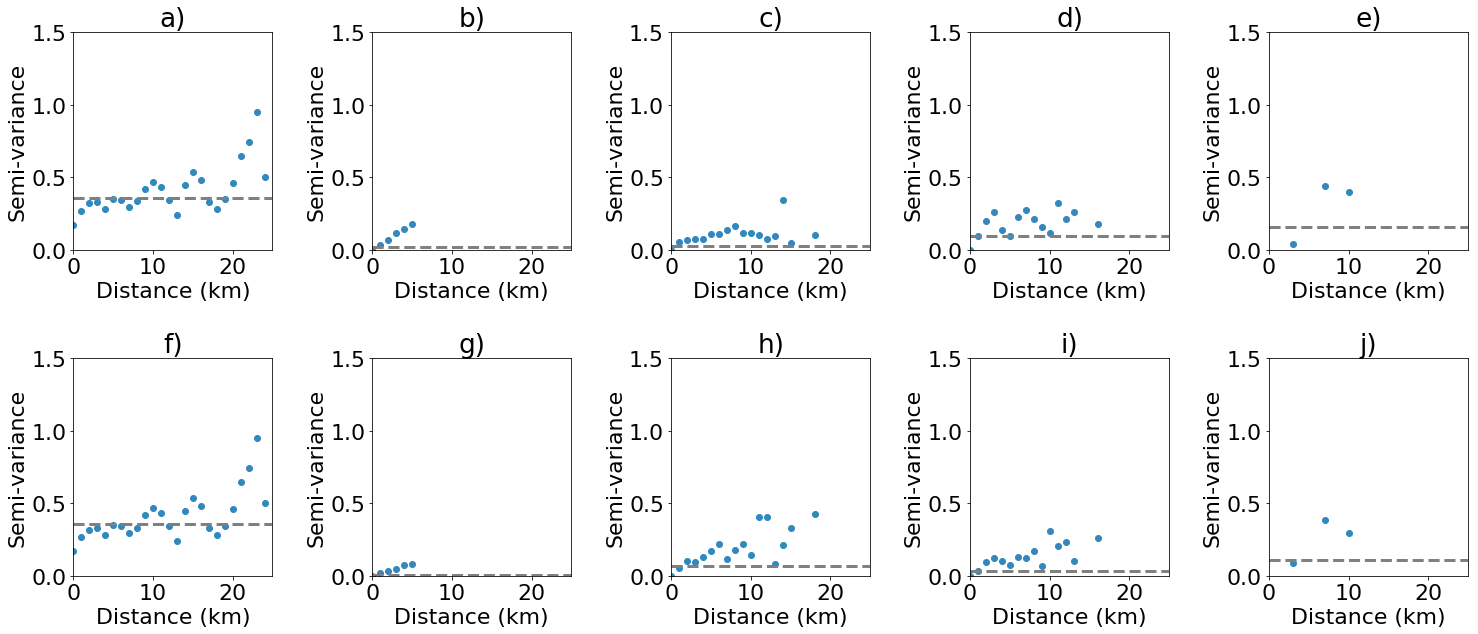

In [339]:
# Model
r_earth = 6371
pts_df = pts.T.to_pandas()
pts_df.index = meta['location:Longitude'].dropna().index
labels = ['All Data', 'Developed, High Intensity' ,'Developed, Med. + Low Intensity', 'Developed, Open Space', 'Deciduous Forest']

# labels = ['All Data', 'Developed, Open space + Developed, Low Intensity',
#  'Developed, Medium + High Intensity',
# # 'Developed, High Intensity',
#  'Deciduous Forest']
fig =plt.figure(figsize=[25,10])
iii = 1
for hr in [6,16]: 
    locations0 = pts_df.values
    data0 = model.mean().values
    
    locations1 = pts_df.loc[lcc[lcc.LCC ==26].index].values
    data1 =  model[model.index.hour==hr][lcc[lcc.LCC ==26].index].mean().values
    
    locations2 = pts_df.loc[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].values
    data2 =  model[model.index.hour==hr][lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean().values
    
    locations3 = pts_df.loc[lcc[lcc.LCC ==23].index].values
    data3 =  model[model.index.hour==hr][lcc[lcc.LCC ==23].index].mean().values    
    
    locations4 = pts_df.loc[lcc[lcc.LCC ==28].index].values
    data4 =  model[model.index.hour==hr][lcc[lcc.LCC ==28].index].mean().values
    
    hs = np.linspace(0,25,26)
    bandwidth =1# np.abs(hs[1]-hs[0])
    for data,locations,label in zip([data0,data1,data2,data3,data4], [locations0,locations1,locations2, locations3,locations4], labels):
        N = data.shape[0]
        ax = plt.subplot(2,5,iii)
        semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
        for h in hs:
            Z = []
            for i in range(N): 
                for j in range(i+1,N): 
                    #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                    distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])#/360*2*np.pi*r_earth
                    if (distance >= h) and (distance< h+bandwidth):
                        Z.append(np.abs(data[i] - data[j])) 
            semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
        ax.scatter(semivariogram.index, semivariogram.semivariogram, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][-1])
        ax.axhline(data.var(), linestyle ='--', color = 'gray')
        ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
        #ax.set_title('%s , %i o\'clock '%(label,hr))
        ax.set_xlabel('Distance (km)')
        ax.set_ylabel('Semi-variance')
        ax.set_ylim([0,1.5])
        ax.set_xlim([0,25])

        iii = iii+1
plt.subplots_adjust(hspace=.5,wspace =0.5)
plt.savefig('figures/semivariogram_model.eps')

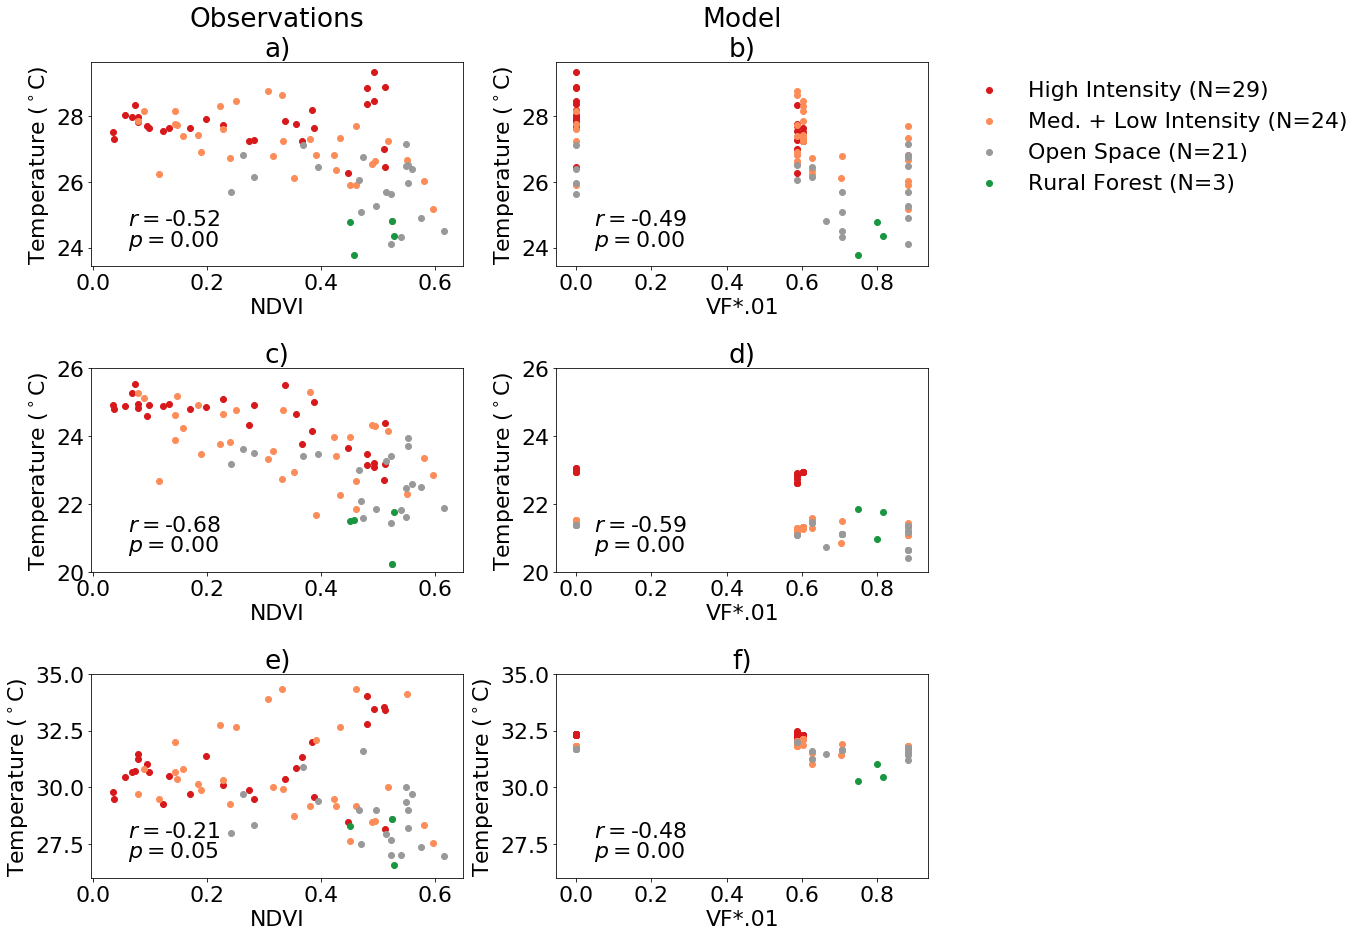

In [727]:
# mean temp vs ndvi/gvf
exp = 'UCM+SST'
dom = 'd03'
vff = pd.read_csv('data/%s_%s_vf.csv'%(exp,dom)).set_index('Unnamed: 0')
satellitedf = pd.read_csv('data/satellite_values.csv').set_index('Unnamed: 0')

fig = plt.figure(figsize=[15,15])
ax = plt.subplot(3,2,1)
x = satellitedf['ndvi'].astype(float).dropna()
y = tempDF.mean()
#plt.scatter(x, y[x.index])
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
    elif lc ==28 : 
        
        plt.scatter(x[[68, 75, 130, 103]], y[[68, 75, 130, 103]])

    else: 
        plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
r,p = scipy.stats.pearsonr(x, y[x.index])
ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
ax.set_xlabel('NDVI')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_title('Observations\na)')

ax = plt.subplot(3,2,2)
x = vff['VF'].astype(float)*.01
y = tempDF.mean()
#plt.scatter(x, y[x.index])
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
    else: 
        plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
r,p = scipy.stats.pearsonr(x, y[x.index])
ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
ax.set_xlabel('VF*.01')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_title('Model\nb)')
#plt.legend(labels,bbox_to_anchor=(1.1, 1.01))
ax.legend(labels,bbox_to_anchor=(1.05, 1.01),frameon=False)

iii = 3
for hr in [6,16]: 
    ax = plt.subplot(3,2,iii)
    x = satellitedf['ndvi'].astype(float).dropna()
    y = tempDF[tempDF.index.hour ==hr].mean()
    #plt.scatter(x, y[x.index])
    for lc in [ 26.,25,23,  28.]:
        if lc == 25: 
            plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
        elif lc ==28: 
            plt.scatter(x[[68, 75, 130, 103]], y[[68, 75, 130, 103]])
        else: 
            plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
    r,p = scipy.stats.pearsonr(x, y[x.index])
    ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
    ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
    ax.set_xlabel('NDVI')
    ax.set_ylabel('Temperature ($^\circ$C)')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
    ax.set_ylim([20,26])

#    ax.set_title('%s) %s o\'clock data'%(string.ascii_lowercase[iii-1],hr))
    iii = iii+1
    
    ax = plt.subplot(3,2,iii)
    x = vff['VF'].astype(float)*.01
    y = model[model.index.hour ==hr].mean()
    #plt.scatter(x, y[x.index])
    for lc in [ 26.,25,23,  28.]:
        if lc == 25: 
            plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
        else: 
            plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
    r,p = scipy.stats.pearsonr(x, y[x.index])
    ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
    ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
    ax.set_xlabel('VF*.01')
    ax.set_ylabel('Temperature ($^\circ$C)')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#    ax.set_title('%s) %s o\'clock data'%(string.ascii_lowercase[iii-1],hr))
    iii = iii+1
    ax.set_ylim([20,26])
plt.subplots_adjust(hspace=.5,wspace =0.25)
#plt.legend(labels,bbox_to_anchor=(1.1, 1.01),frameon=False)
plt.subplot(3,2,5).set_ylim([26,35])
plt.subplot(3,2,6).set_ylim([26,35])
plt.savefig('figures/vegetation_fraction.eps',bbox_inches='tight')

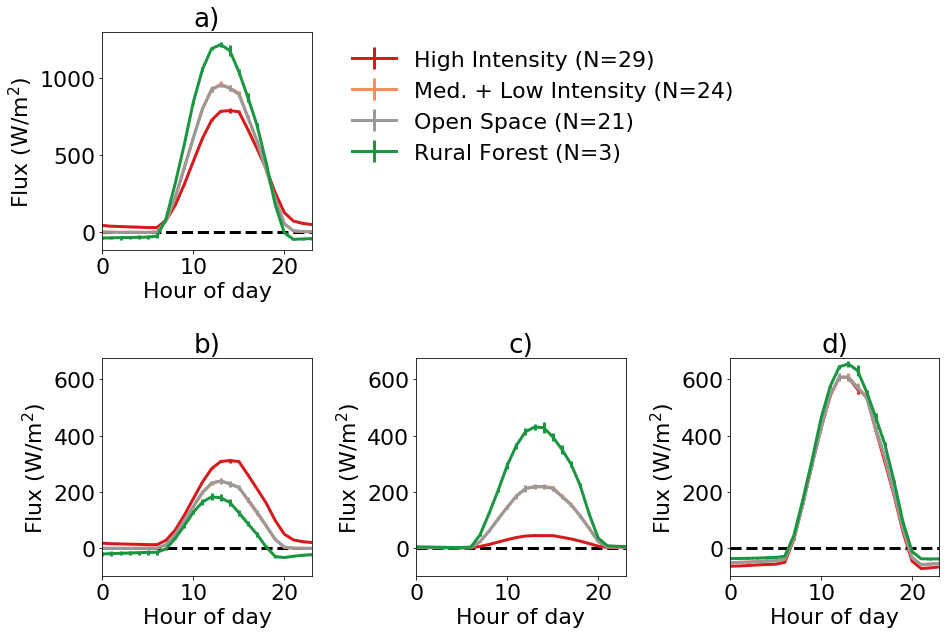

In [875]:
# SEB plots
#em = getvar(dataset_list[-1], 'EMISS')
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d_%H:%M:%S') -pd.Timedelta('4h')
model_allvars = pd.read_csv('UCM+SST_d03_allpoints_allvars.csv',header = [0,1], index_col=0,
                        parse_dates = [0], 
                   date_parser = date_parser,
                       skipinitialspace=True)#[tempDF.index[0]:tempDF.index[-1]]
model_allvars.columns.set_levels(model_allvars.columns.levels[1].astype(int), level = 1, inplace = True)
net_lw = model_allvars['LWDNB'].subtract(model_allvars['LWUPB'])
net_sw = (model_allvars['SWDNB'].subtract(model_allvars['SWUPB']))#.add(model_allvars['net_lw'],axis=0)
rnet = net_lw+net_sw

fig = plt.figure(figsize=[15,10])
ax = plt.subplot(2, 3,1)
#netflux = rnet -  model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] -  model_allvars.loc[:,'GRDFLX']
netflux = rnet + model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] + model_allvars.loc[:,'GRDFLX']

for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    else: 
        netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.legend(labels, bbox_to_anchor=(1.1, 1.01), frameon=False)
#plt.xticks([6,12,16])
plt.title('a)')#Average Net Flux')
plt.xlabel('Hour of day')
ax.set_ylabel('Flux (W/m$^2$)')
#plt.ylabel(' (Wm$^{-2}$)')
plt.axhline(0, color ='k', linestyle = '--')
# want: 'R_net', 'Net LW','Sensible', 'Latent', 'Ground flux',
#selected_vars = ['GRDFLX','LH','HFX' ]
selected_vars = ['HFX','LH', ]
#['T2', 'SWDNB', 'SWUPB', 'LWDNB', 'LWUPB', 'LH', 'HFX', 'GRDFLX','CLDFRA', 'QVAPOR',]
#plt.figure(figsize=[20,5])
i = 4
for var in selected_vars:
    #ax = plt.subplot(1, 4,i)
    ax = plt.subplot(2,3,i)
    data = model_allvars.loc[:,var]
    for lc in [ 26.,25,23,  28.]:
        if lc == 25: 
            data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                                label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
        else: 
            data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                           label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    ax.set_title('%s)'%(string.ascii_lowercase[i-3]))
#    ax.set_title(var)
    ax.set_ylim([-100,675])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')
    #plt.xticks([6,12,16])
    i = i+1
    plt.axhline(0, color ='k', linestyle = '--')
#ax = plt.subplot(1, 4,i)
ax = plt.subplot(2,3,i)
data = model_allvars.loc[:,var]
for lc in [ 26.,25,23,  28.]:
    if lc == 25 : 
        rnet[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr= rnet[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else : 
        rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr =rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1) , 
                                                                                       label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    ax.set_title('%s)'%(string.ascii_lowercase[i-3]))
    ax.set_ylim([-100,675])
    #plt.xticks([6,12,16])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')
plt.axhline(0, color ='k', linestyle = '--')
#ax.set_title('r_net')
plt.subplots_adjust(hspace=.5,wspace =0.5)
#plt.legend(bbox_to_anchor=(1.1, 1.01), frameon=False)
plt.savefig('figures/SEB.eps', bbox_inches='tight')
# caption: net flux, sensible, latent heat, net radiation

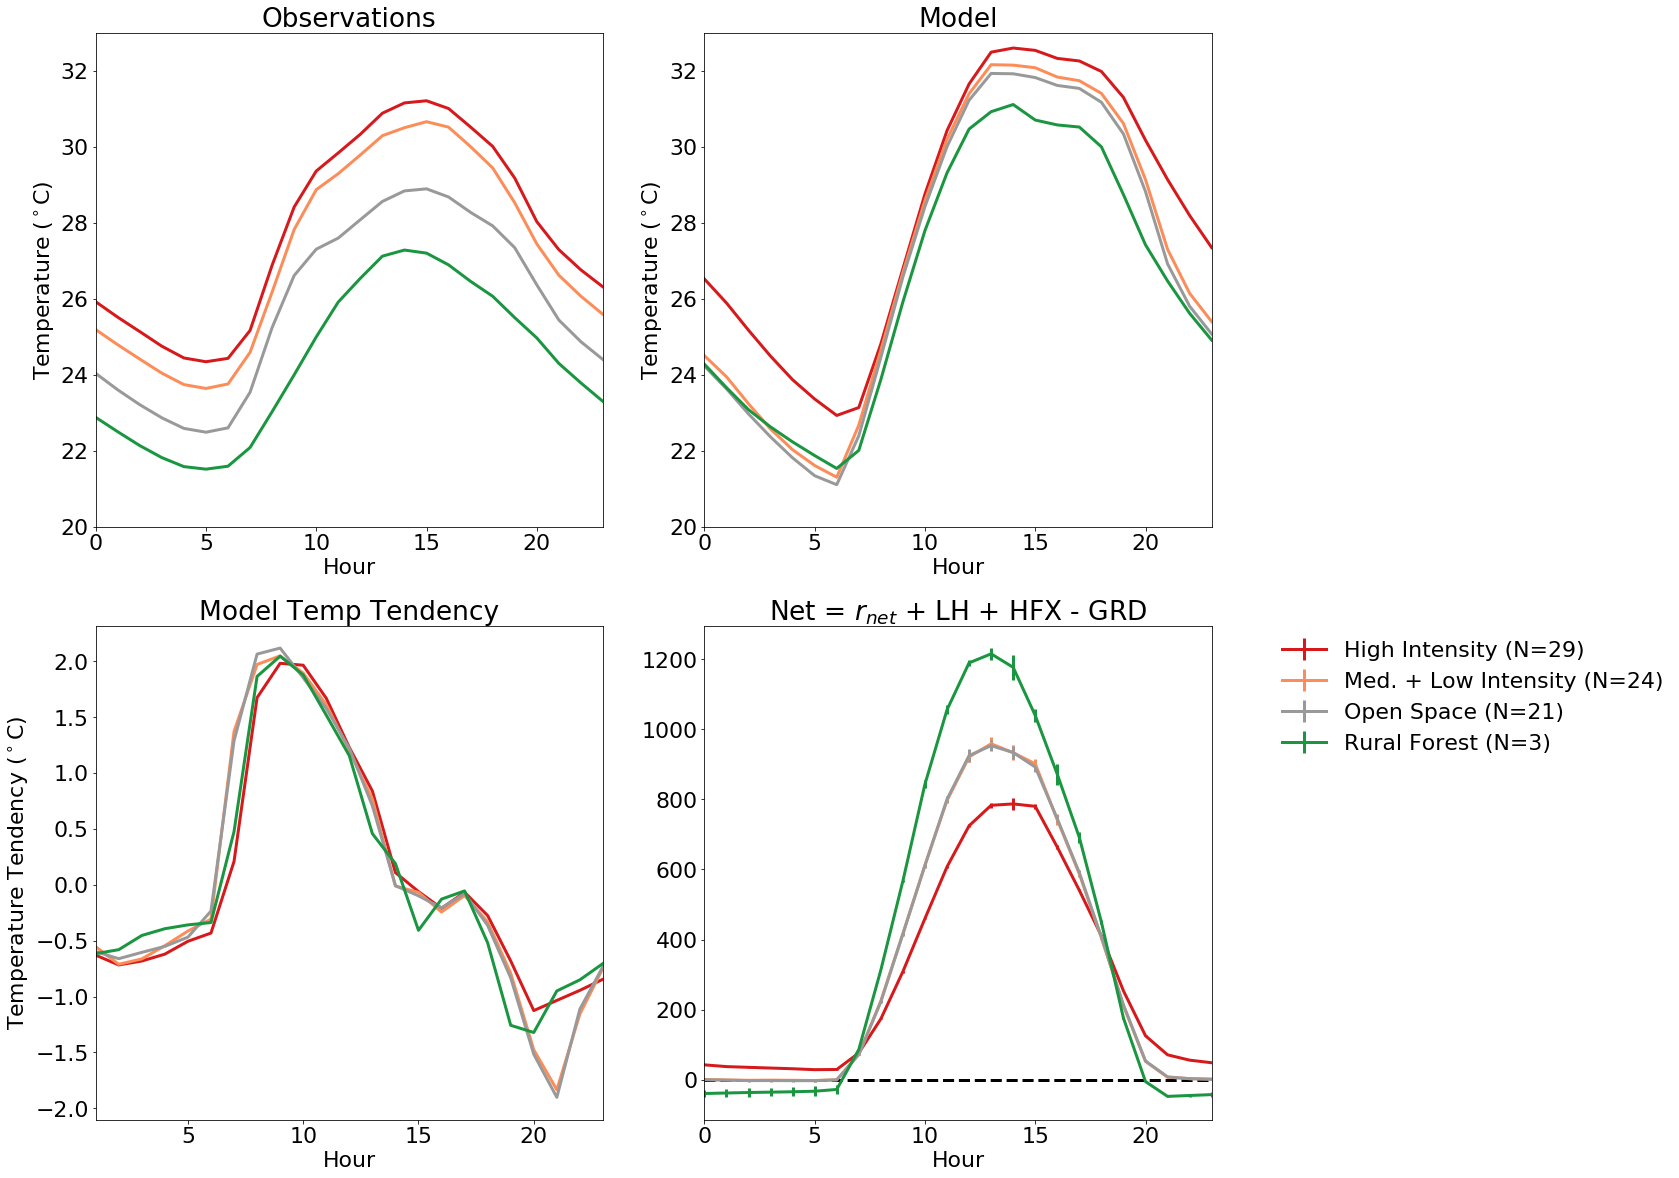

In [876]:
# group meeting slide 
# Temperature, temperature tendency, Flux 
plt.figure(figsize=[20,20])
ax = plt.subplot(2,2,1)
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25: 
        tempDF[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
ax.set_title('Observation\na)')
ax.set_ylabel('Temperature ($^\circ$C)')
#plt.legend(np.concatenate([selected_labels.label.values, ['ASOS']],axis=0))
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
#labels = ['High Intensity' ,'Med. + Low Intensity', 'Open Space', 'Rural Forest']
labels = ['High Intensity (N=29)' ,'Med. + Low Intensity (N=24)', 'Open Space (N=21)', 'Rural Forest (N=3)', 'Urban Forest (N=16)']
#plt.legend(labels, bbox_to_anchor=(2.2, 1.01),loc=2,frameon=False)
ax.set_title('Observations')

ax = plt.subplot(2,2,2)
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25:
        model[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
#plt.legend()
ax.set_title('Model\nb)')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
ax.set_title('Model')

ax = plt.subplot(2,2,3)
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25:
        diurnal = model[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model.index.hour).mean().mean(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        diurnal = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)#
    (diurnal.iloc[1:].subtract(diurnal.iloc[0:-1].values)).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
#plt.legend()
ax.set_title('Model')
ax.set_ylabel('Temperature Tendency ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_xlabel('Hour')
ax.set_title('Model Temp Tendency')


ax = plt.subplot(2,2,4)
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    else: 
        netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.legend(labels, bbox_to_anchor=(1.1, 1.01), frameon=False)
ax.set_xlabel('Hour')
plt.axhline(0, color ='k', linestyle = '--')
plt.title('Net = $r_{net}$ + LH + HFX + GRD')
plt.savefig('figures/group_meetingApr11.eps', bbox_inches='tight')

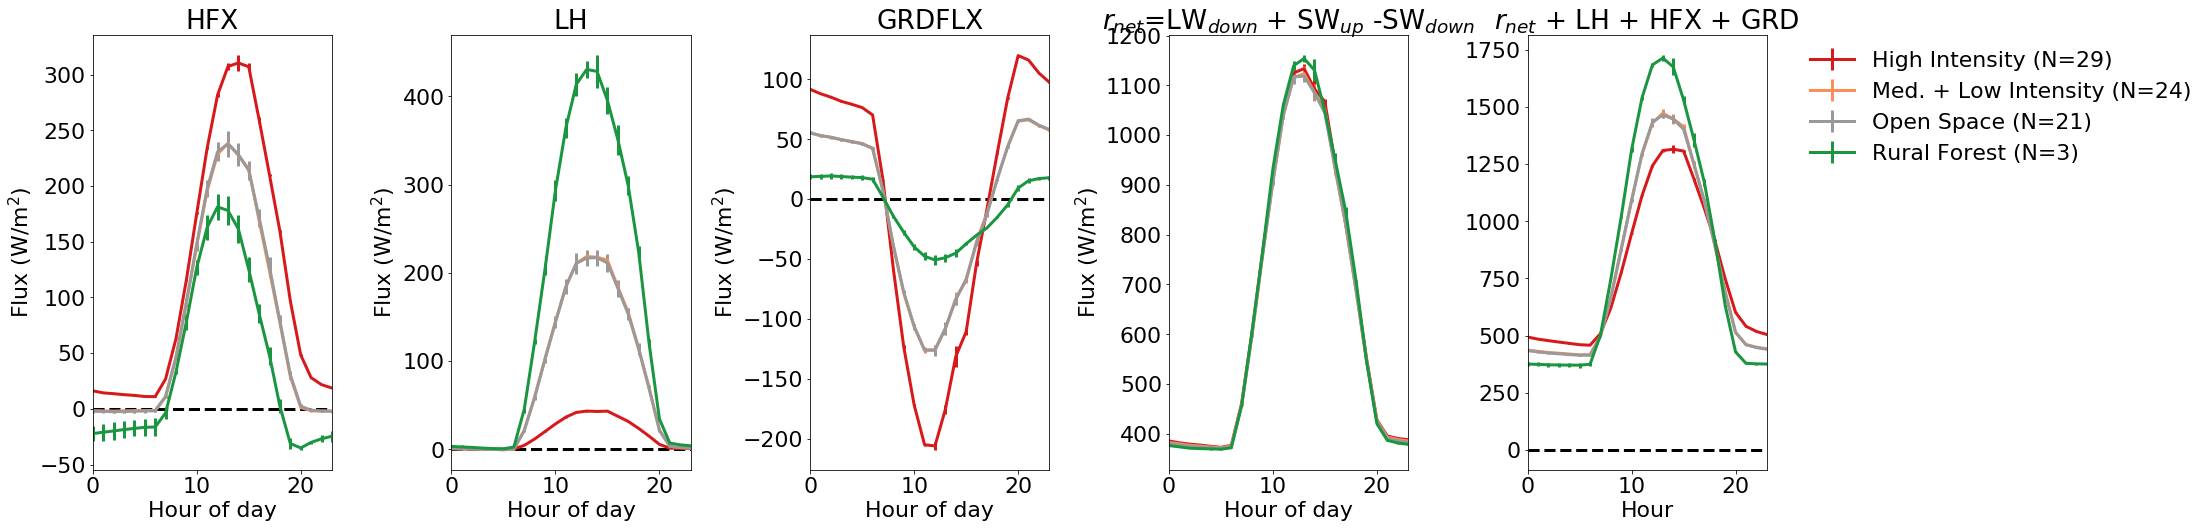

In [891]:
selected_vars = ['HFX','LH','GRDFLX' ]
net_lw = model_allvars['LWDNB'].subtract(model_allvars['LWUPB'])
net_sw = (model_allvars['SWDNB'].subtract(model_allvars['SWUPB']))#.add(model_allvars['net_lw'],axis=0)
#rnet = net_lw+net_sw
rnet = model_allvars['LWDNB']+net_sw
netflux = rnet + model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] + model_allvars.loc[:,'GRDFLX']


plt.figure(figsize=[30,8])
#['T2', 'SWDNB', 'SWUPB', 'LWDNB', 'LWUPB', 'LH', 'HFX', 'GRDFLX','CLDFRA', 'QVAPOR',]
#plt.figure(figsize=[20,5])
i = 1
for var in selected_vars:
    #ax = plt.subplot(1, 4,i)
    ax = plt.subplot(1,5,i)
    data = model_allvars.loc[:,var]
    for lc in [ 26.,25,23,  28.]:
        if lc == 25: 
            data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                                label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
        else: 
            data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                           label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    ax.set_title('%s)'%(string.ascii_lowercase[i-3]))
    ax.set_title(var)
    #ax.set_ylim([-100,675])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')
    #plt.xticks([6,12,16])
    i = i+1
    plt.axhline(0, color ='k', linestyle = '--')
    

ax = plt.subplot(1,5,4)
for lc in [ 26.,25,23,  28.]:
    if lc == 25 : 
        rnet[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr= rnet[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else : 
        rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr =rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1) , 
                                                                                       label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    ax.set_title('$r_{net}$=LW$_{down}$ + SW$_{up}$ -SW$_{down}$')#%s)'%(string.ascii_lowercase[i-3]))
    #ax.set_ylim([-100,675])
    #plt.xticks([6,12,16])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')

ax = plt.subplot(1,5,5)
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    else: 
        netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.legend(labels, bbox_to_anchor=(1.1, 1.01), frameon=False)
ax.set_xlabel('Hour')
plt.axhline(0, color ='k', linestyle = '--')
plt.title('$r_{net}$ + LH + HFX + GRD')
plt.subplots_adjust(wspace =0.5)

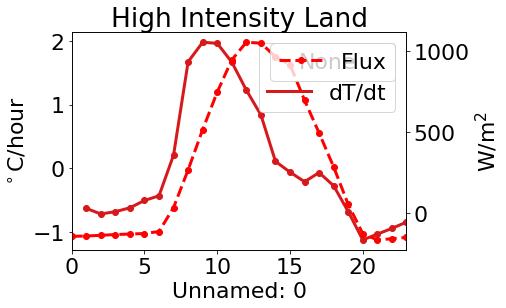

In [870]:
lc = 26 
diurnal = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)#
dTdt = (diurnal.iloc[1:].subtract(diurnal.iloc[0:-1].values))
flux = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1)

dTdt.plot(style = '-o', label = 'Temp Tendency', )
plt.legend(['dT/dt'], loc=1)
plt.ylabel('$^\circ$C/hour')
flux.plot(secondary_y = True, style = '--or', label = 'Flux')
plt.ylabel('W/m$^2$')
plt.legend(loc=1)
plt.title('High Intensity Land')
plt.xlabel('Hour')
plt.savefig('figures/group_meetingApr11_extra.eps', bbox_inches='tight')

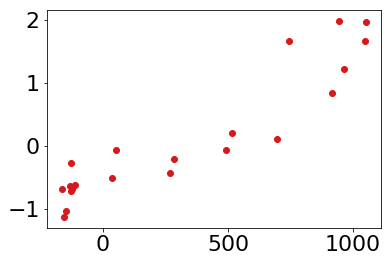

In [836]:
lag = 3
plt.scatter(flux.iloc[lag:].values, dTdt[0:-lag+1].values)
plt.title('')

In [808]:
lag

1

In [826]:
lag

2

In [827]:
flux.iloc[lag:].shape

(22,)

In [828]:
dTdt[0:-lag+1].shape

(22,)

In [835]:
print(np.corrcoef(flux.iloc[1:].values, dTdt.values)[0,1])
for lag in range(2,5) : 
    print(np.corrcoef(flux.iloc[lag:].values, dTdt[0:-lag+1].values)[0,1])

0.697461578047
0.846086088951
0.922076955076
0.906947707673


In [825]:
np.corrcoef(flux.iloc[lag:].values, dTdt.values)[0,1]
for lag in range(2,5) : 
    np.corrcoef(flux.iloc[lag:].values, dTdt[0:-lag+1].values)[0,1]

ValueError: all the input array dimensions except for the concatenation axis must match exactly

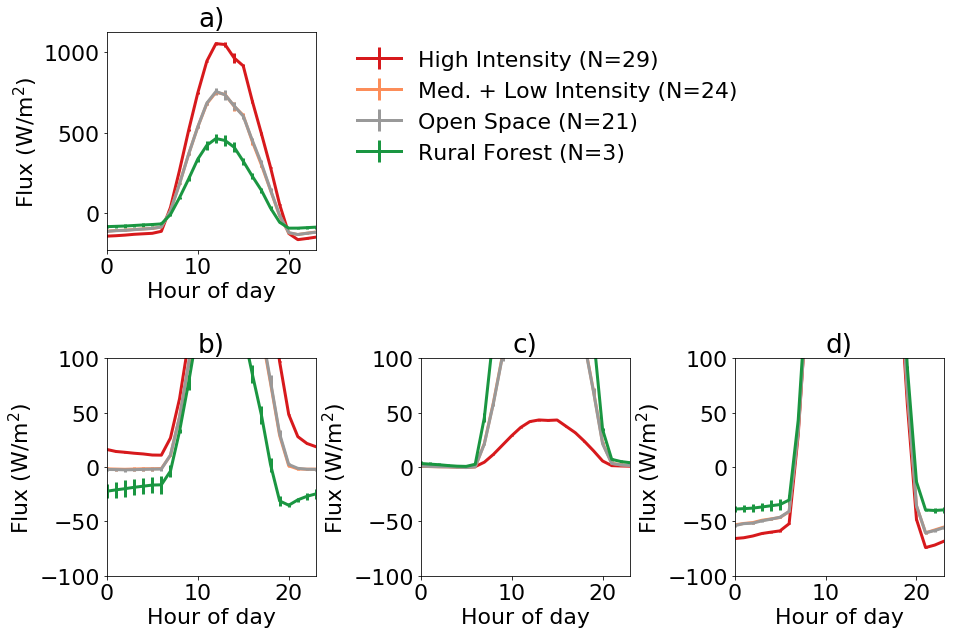

In [789]:
fig = plt.figure(figsize=[15,10])
ax = plt.subplot(2, 3,1)
netflux = rnet -  model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] -  model_allvars.loc[:,'GRDFLX']
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    else: 
        netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.legend(labels, bbox_to_anchor=(1.1, 1.01), frameon=False)
#plt.xticks([6,12,16])
plt.title('a)')#Average Net Flux')
plt.xlabel('Hour of day')
ax.set_ylabel('Flux (W/m$^2$)')
#plt.ylabel(' (Wm$^{-2}$)')

# want: 'R_net', 'Net LW','Sensible', 'Latent', 'Ground flux',
#selected_vars = ['GRDFLX','LH','HFX' ]
selected_vars = ['HFX','LH', ]
#['T2', 'SWDNB', 'SWUPB', 'LWDNB', 'LWUPB', 'LH', 'HFX', 'GRDFLX','CLDFRA', 'QVAPOR',]
#plt.figure(figsize=[20,5])
i = 4
for var in selected_vars:
    #ax = plt.subplot(1, 4,i)
    ax = plt.subplot(2,3,i)
    data = model_allvars.loc[:,var]
    for lc in [ 26.,25,23,  28.]:
        if lc == 25: 
            data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                                label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
        else: 
            data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                           label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    ax.set_title('%s)'%(string.ascii_lowercase[i-3]))
#    ax.set_title(var)
    ax.set_ylim([-100,100])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')
    #plt.xticks([6,12,16])
    i = i+1
    
#ax = plt.subplot(1, 4,i)
ax = plt.subplot(2,3,i)
data = model_allvars.loc[:,var]
for lc in [ 26.,25,23,  28.]:
    if lc == 25 : 
        rnet[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr= rnet[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else : 
        rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr =rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1) , 
                                                                                       label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    ax.set_title('%s)'%(string.ascii_lowercase[i-3]))
    ax.set_ylim([-100,100])
    #plt.xticks([6,12,16])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')

#ax.set_title('r_net')
plt.subplots_adjust(hspace=.5,wspace =0.5)

3

In [384]:
em = getvar(Dataset(files[0]), "EMISS")
emm = np.diagonal(em.isel(west_east = all_pts.values[0], south_north = all_pts.values[1]), axis1=0,axis2=1)
emissivity = pd.DataFrame(emm, index = meta['location:Latitude'].dropna().index.astype('int64') )
emissivity

,0
sensornumber,
82,0.97
139,0.90
130,0.93
32,0.97
10,0.88
129,0.97
105,0.90
80,0.88
34,0.97


In [413]:
for lc in [26,25,24,23, 28]: #lcc.LCC.unique(): 
    mean = emissivity.loc[lcc[lcc.LCC==lc].index].mean().values
    std = emissivity.loc[lcc[lcc.LCC==lc].index].std().values
    print('LCC = %i, mean = %2.2f, std = %2.2f'%(lc, mean, std))

LCC = 26, mean = 0.88, std = 0.00
LCC = 25, mean = 0.90, std = 0.00
LCC = 24, mean = 0.95, std = 0.00
LCC = 23, mean = 0.97, std = 0.00
LCC = 28, mean = 0.93, std = 0.00


In [418]:
for lc in [26,25,24,23, 28]: #lcc.LCC.unique(): 
    mean = vff.loc[lcc[lcc.LCC==lc].index].mean().values
    std = vff.loc[lcc[lcc.LCC==lc].index].std().values
    print('LCC = %i, mean VF = %2.2f, std = %2.2f'%(lc, mean, std))

LCC = 26, mean VF = 24.53, std = 29.72
LCC = 25, mean VF = 50.75, std = 28.27
LCC = 24, mean VF = 77.44, std = 12.00
LCC = 23, mean VF = 61.81, std = 32.61
LCC = 28, mean VF = 78.80, std = 3.44


(<xarray.DataArray u'xy' ()>
 array(10)
 Coordinates:
     latlon_coord  object CoordPair(lat=39.29813979, lon=-76.69014149)
     x_y           <U1 u'y', <xarray.DataArray u'xy' ()>
 array(308)
 Coordinates:
     latlon_coord  object CoordPair(lat=39.28520643, lon=-76.54833725)
     x_y           <U1 u'y')

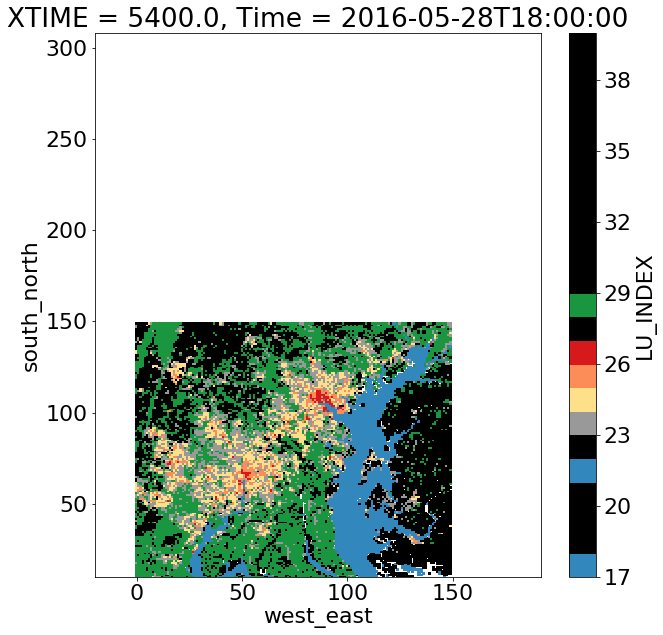

In [720]:
# Fig. 1: A map with insets, some points
# exp = 'UCM+SST'
# dom = 'd03'
# fpath = home_dir + '/mountpoint/wrf/out/'
# files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
# ds = Dataset(files[30*3])
# lu = getvar(ds, "LU_INDEX")
# all_pts = wrf.ll_to_xy(ds, meta['location:Latitude'].dropna().values,
#                        meta['location:Longitude'].dropna().values)
color_dict ={26.: '#d7191c',
             25 : '#fc8d59',
             24: '#fee08b', #'yellow',
             23: '#999999',
             28: '#1a9641', 
             21: '#3288bd',
             17: '#3288bd'
            }
cmap = ['k' for x in range(17,40)]
#cmap = ['#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3','#f5f5f5','#c7eae5','#80cdc1','#35978f','#01665e','#003c30', '#762a83','#af8dc3','#e7d4e8',]

for x in color_dict.keys(): 
    x = int(x)
    cmap[x-17] = color_dict[x]
#lu.plot(levels = 24, cmap  = cm.tab20, figsize = [10,10])
lu.plot(levels = 24,  
        cmap = cmap, 
        vmin = 17, vmax =40, figsize = [10,10])
#plt.scatter(all_pts[0], all_pts[1], marker = '^', color = 'k')
# plt.xlim(pts[0].values)
# plt.ylim(pts[1].values)
plt.xlim(pts[0][0]-100, pts[0][1]+100)
plt.ylim(pts[1][0]-100, pts[1][1]+200)

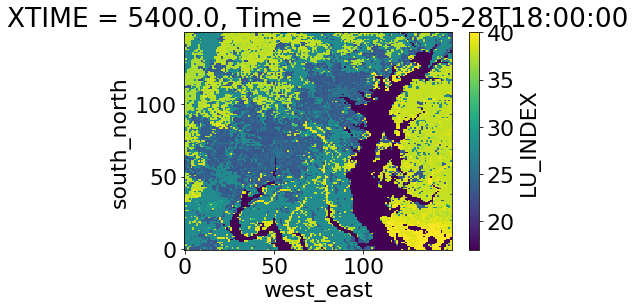

In [721]:
fig = plt.figure()
ax = plt.subplot(1,3,1) 
lu.plot()
ax = plt.subplot(1,3,2) 


In [724]:
ds.variables

OrderedDict([(u'Times', <type 'netCDF4._netCDF4.Variable'>
              |S1 Times(Time, DateStrLen)
              unlimited dimensions: Time
              current shape = (1, 19)
              filling on, default _FillValue of   used),
             (u'XLAT', <type 'netCDF4._netCDF4.Variable'>
              float32 XLAT(Time, south_north, west_east)
                  FieldType: 104
                  MemoryOrder: XY 
                  description: LATITUDE, SOUTH IS NEGATIVE
                  units: degree_north
                  stagger: 
                  coordinates: XLONG XLAT
              unlimited dimensions: Time
              current shape = (1, 150, 150)
              filling on, default _FillValue of 9.96920996839e+36 used),
             (u'XLONG', <type 'netCDF4._netCDF4.Variable'>
              float32 XLONG(Time, south_north, west_east)
                  FieldType: 104
                  MemoryOrder: XY 
                  description: LONGITUDE, WEST IS NEGATIVE
           